# MIR Final Project: Comparison of 2-D Timbre Spaces for Freesound Sounds
### Gonzalo Nieto Montero 28-03-2021

The goal of this notebook is to compare different 2-D timbre spaces to visualize Freesound sounds. Two feature extraction methods and two dimensionality reduction methods are compared. The combination of these methods results in four spaces: (i) **hand-crafted features + PCA**, (ii) **hand-crafted features + t-SNE**, (iii) **AudioSet features + PCA** and (iv) **AudioSet features + t-SNE**. More information about the dimensionality reduction and feature extraction techniques is given in the following cells.

The dataset used is the **evaluation partition of [FSD50K](https://zenodo.org/record/4060432)**, with its ground truth annotations, although not entirely (more details below). The reason why this partition is chosen is because it has a more appropiate size for the magnitude of this small research, and it is "labeled exhaustively (labels are correct and complete for the considered vocabulary)". 

*The total execution time of this notebook is estimated to be close to 15 minutes, including data loading and feature extration processes.*

## Dataset
Evaluation partition of [FSD50K](https://zenodo.org/record/4060432), with ground truth labels.

### Data loading and setting up
*This part should take 8 minutes approximately.*

Install Essentia audio feature extraction library and a utility to download from Zenodo.

In [1]:
%%capture
!pip install essentia
!pip3 install zenodo_get

Download the FSD50K dataset. First download a file which contains direct links to the Zenodo site (using its DOI), then download only the evaluation set and the ground truth annotations. 

*This download should take around 4 minutes.*

In [2]:
import wget
import os
outputdir = './FSD50K_part'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

!zenodo_get -w ./download_FSD50K.txt 10.5281/zenodo.4060431
f = open("download_FSD50K.txt", "r")
download_list = f.read().split('\n')
for links in download_list:
  if "eval_audio" in links or "ground_truth" in links:
    print("Downloading:",links)
    wget.download(links, out=outputdir)


Downloading: https://zenodo.org/record/4060432/files/FSD50K.eval_audio.z01
Downloading: https://zenodo.org/record/4060432/files/FSD50K.eval_audio.zip
Downloading: https://zenodo.org/record/4060432/files/FSD50K.ground_truth.zip


Unzip downloaded files. First merge different zip parts into one zip file called unsplit.

*This process takes around 4 minutes.*

In [3]:
!zip -s 0 ./FSD50K_part/FSD50K.eval_audio.zip --out ./FSD50K_part/unsplit.zip 
!unzip ./FSD50K_part/unsplit.zip -d ./FSD50K_part
!unzip ./FSD50K_part/FSD50K.ground_truth.zip -d ./FSD50K_part

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ./FSD50K_part/FSD50K.eval_audio/172858.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/250098.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/171973.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/402569.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/189620.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/137894.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/390340.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/405267.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/135848.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/369598.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/110584.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/97756.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/236294.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/369265.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/93790.wav  
  inflating: ./FSD50K_part/FSD50K.eval_audio/344679.wav  
  inflating: 

##### Util function to calculate file duration without loading audio (faster).

In [4]:
import os

In [5]:
def audio_duration(filename):
  # bitdepth and sample rate of all clips in FSD50K 
  bitdepth = 16
  samplerate = 44100
  # duration of uncompressed PCM wav file
  dur = os.path.getsize(filename)/bitdepth*8/samplerate
  return dur

### Data visualization and understanding


##### AudioSet ontology
Since the ground truth labels of FSD50K are given according to the [AudioSet ontology](https://research.google.com/audioset/ontology/index.html), it is important to understand this ontology. AudioSet is a collection of 2,084,329 human labeled 10-second sound clips drawn from YouTube videos organized hierarchically in 632 audio event classes. This classification is meant for the general task of audio event detection. The classification can be browsed from here:

In [6]:
from IPython.display import IFrame
IFrame(src='https://research.google.com/audioset/ontology/index.html', width=700, height=800)

##### FSD50K evaluation set: overview
In order to get a big picture of the data, ground truth annotations are loaded and visualized in different ways.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

gt = pd.read_csv('./FSD50K_part/FSD50K.ground_truth/eval.csv')

First of all, it can be seen that the 6 main classes of the AudioSet ontology are not present in the dataset. However, after doing a quick search, it can be noticed that there are in fact natural and human sounds (and probably the same happens with the other 3 categories). Therefore, this representation is not very meaningful, it just shows that the 200 classes used in FSD50K are a subset of the 632 classes of the Audioset ontology.

There is a total of 10231 sounds in the FSD50K evaluation set.

Number of sounds labeled as 'Music': 1972

Number of sounds labeled as 'Animal': 1082

Total number of sounds: 10231



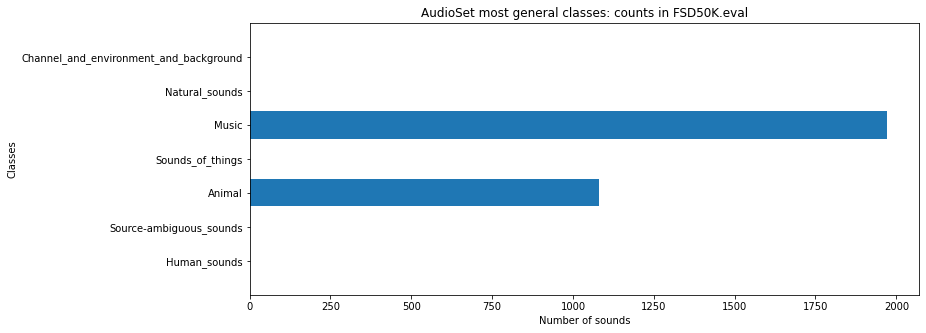

In [8]:
audioset_main_classes = [
    'Human_sounds',
    'Source-ambiguous_sounds',
    'Animal',
    'Sounds_of_things',
    'Music',
    'Natural_sounds',
    'Channel_and_environment_and_background']

general_classes = dict()
for classes in audioset_main_classes:
  num_sounds_per_class = len(gt[gt['labels'].str.contains(classes)])
  general_classes[classes] = num_sounds_per_class

# Plot
plt.figure(figsize=[12,5])
plt.title("AudioSet most general classes: counts in FSD50K.eval")
x = list(general_classes.values())
y_text = list(general_classes.keys())
y = range(len(y_text))
plt.barh(y, x, align='center')
plt.yticks(y, y_text)
plt.ylim([-1, len(y)])
plt.xlabel('Number of sounds')
plt.ylabel('Classes')
print(f"Number of sounds labeled as 'Music': {general_classes['Music']}\n")
print(f"Number of sounds labeled as 'Animal': {general_classes['Animal']}\n")
print(f"Total number of sounds: {len(gt)}\n")

In the following cell a plot of the labels that occur more than 400 classes is shown. It can be seen that they are varied and they overlap (for instance Wild_animals and Bird), as sounds are multilabeled.

It is confirmed that there is a total of 200 labels.

Total number of labels: 200 

Number of commmon (greater than 400) labels: 22 



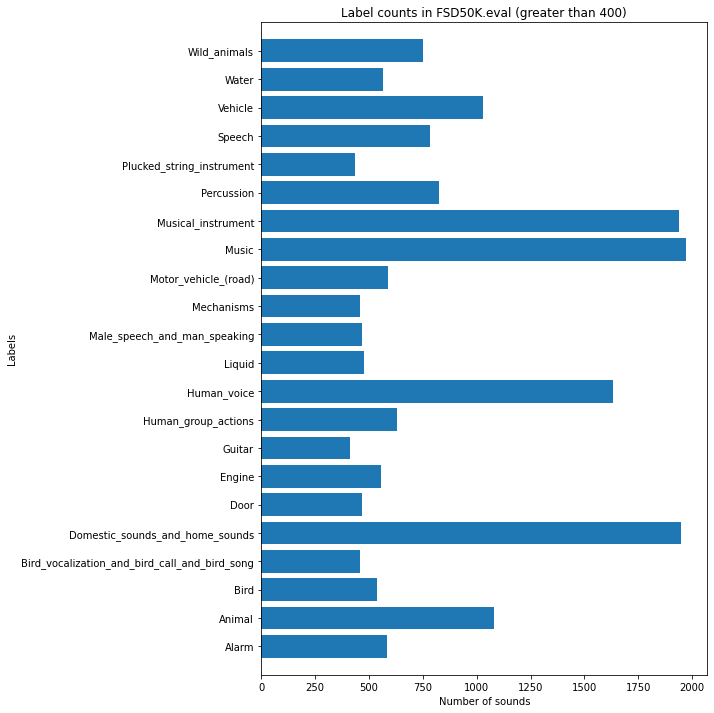

In [9]:
# Calculate the number of sounds for of all classes
gt_split = gt['labels'].str.split(',', expand=True) # make different columns for different labels
labels_counts = gt_split.apply(pd.Series.value_counts).sum(axis = 1, skipna = True)

# Take only counts greater than min
min = 400
common_labels_counts = labels_counts[labels_counts>min]

# Plot
plt.figure(figsize=[8,12])
plt.title(f"Label counts in FSD50K.eval (greater than {min})")
x = list(common_labels_counts)
y_text = list(common_labels_counts.keys())
y = range(len(y_text))
plt.barh(y, x, align='center')
plt.yticks(y, y_text)
plt.ylim([-1, len(y)])
plt.xlabel('Number of sounds')
plt.ylabel('Labels')

print("Total number of labels:", len(labels_counts.keys()), "\n")
print(f"Number of commmon (greater than {min}) labels:", len(y_text), "\n")

There are in fact 9093 multi-labeled sounds and 1138 single-labeled sounds.

Number of single-labeled sounds: 1138

Number of multi-labeled sounds: 9093



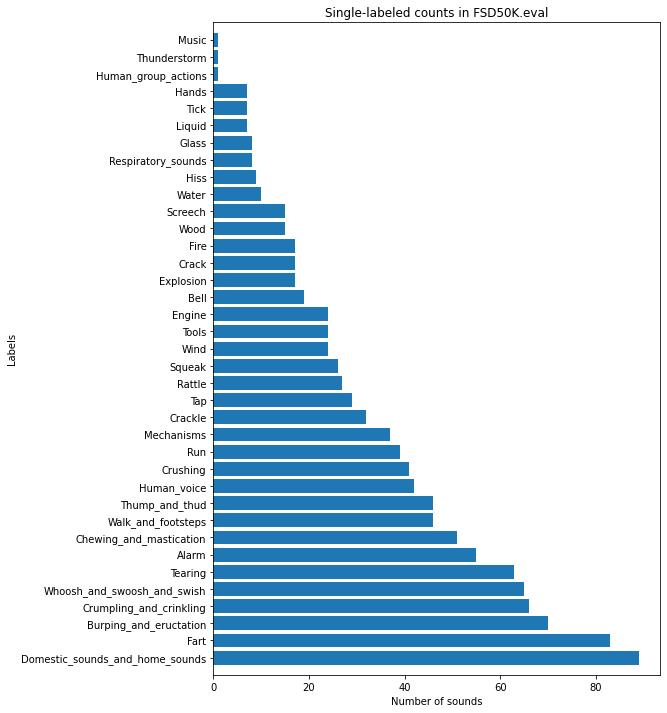

In [10]:
# Calculate the number of sounds that are single-labeled
single_label_bool = ~gt['labels'].str.contains(',')
single_labeled = gt[single_label_bool]
single_counts = single_labeled['labels'].value_counts()

# Plot
plt.figure(figsize=[8,12])
plt.title(f"Single-labeled counts in FSD50K.eval")
x = list(single_counts)
y_text = list(single_counts.keys())
y = range(len(y_text))
plt.barh(y, x, align='center')
plt.yticks(y, y_text)
plt.ylim([-1, len(y)])
plt.xlabel('Number of sounds')
plt.ylabel('Labels')
print(f"Number of single-labeled sounds: {sum(single_counts)}\n")
print(f"Number of multi-labeled sounds: {len(gt)-sum(single_counts)}\n")

##### Selected classes
As it has been mentioned, the classes of FSD50K are thought for audio event classification, which differs a bit from timbre classification. For this reason, all labels are not valid for the present task. As a solution, two pair of labels are selected following these criteria:


*   Labels should be specific enough, so they share a common timbre and are not mixed with other sounds (in the majority of the cases alt least).
*   Labels should be contrasting enough, so they have 'opposite' timbres.
*   Labels should be big enough in number of samples, so they represent some variety.

The pairs of labels selected are: Singing vs. Gunshot_and_gunfire and Fart vs. Bell. Both cases are pitched and noisy sounds vs. unpitched and tonal sounds.

More over, a maximum of 10 seconds duration is set, to increase the chance of obtaining one-shot sounds and because the final application (concatenative synthesis) allows it.



{'Bell': 386, 'Fart': 97, 'Gunshot_and_gunfire': 134, 'Singing': 194}

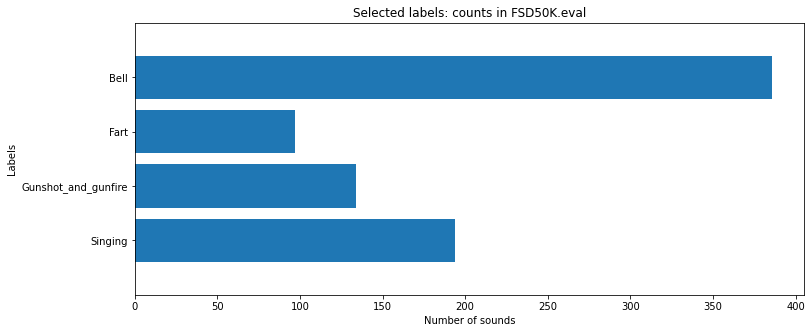

In [11]:
selected_classes = [
    'Singing',
    'Gunshot_and_gunfire',
    'Fart',
    'Bell']

sel_classes = dict()
for classes in selected_classes:
  num_sounds_per_class = len(gt[gt['labels'].str.contains(classes)])
  sel_classes[classes] = num_sounds_per_class

# Plot
plt.figure(figsize=[12,5])
plt.title("Selected labels: counts in FSD50K.eval")
x = list(sel_classes.values())
y_text = list(sel_classes.keys())
y = range(len(y_text))
plt.barh(y, x, align='center')
plt.yticks(y, y_text)
plt.ylim([-1, len(y)])
plt.xlabel('Number of sounds')
plt.ylabel('Labels')
sel_classes

Take random sounds from the selected labels to have a listen.


In [36]:
import random
from IPython.display import Audio, display
import pandas as pd

gt = pd.read_csv('./FSD50K_part/FSD50K.ground_truth/eval.csv')
audios_path = './FSD50K_part/FSD50K.eval_audio'

# Make a random choice for each label
for classes in selected_classes:
  tmp = list(gt[gt['labels'].str.contains(classes)]['fname'])
  sound = random.choice(tmp)

  print(f'Label {classes} – sound {sound}\n')
  if audio_duration(f'{audios_path}/{sound}.wav') > 10:
    print("(random audio longer than 10. This audio is discarded at the end)\n")
  display(Audio(f'{audios_path}/{sound}.wav'))

Output hidden; open in https://colab.research.google.com to view.

## Feature Extraction
Two methods used: hand-crafted features and VGGish pretrained model as feature extractor.

### Method 1: hand-crafted features
This method consists of extracting a set of features that are know to be relevant in timbre perception using Essentia. These selected features are: MFCCs, spectral centroid, spectral spread, spectral complexity, dissonance, log attack time and pitch.

Create a function that extracts the audio features for a given sound.


In [13]:
import essentia.standard as es

def compute_features(filename, sr=44100):
    audio = es.MonoLoader(filename=filename, sampleRate=sr)()
    
    features_all = es.Extractor(rhythm=False, highLevel=True, midLevel=False, lowLevel=True)(audio)
    
    mfcc = features_all["lowLevel.mfcc"]
    
    spectral_centroid = features_all["lowLevel.spectral_centroid"]
    
    spectral_spread = features_all["lowLevel.spectral_spread"]
    
    spectral_complexity = features_all["lowLevel.spectral_complexity"]
    
    dissonance = features_all["lowLevel.dissonance"]

    log_attack_time, _, _ = es.LogAttackTime(sampleRate=sr)(audio)

    pitch = features_all["sfx.pitch_centroid"]

    feature_array = []
      
    # We append the means of the features:
    mfcc_mean = np.mean(mfcc,axis=0)
    for mfcc_val in np.nditer(mfcc_mean):
      feature_array.append(mfcc_val)
    feature_array.append(np.mean(spectral_centroid,axis=0))
    feature_array.append(np.mean(spectral_spread,axis=0))
    feature_array.append(np.mean(spectral_complexity,axis=0))
    feature_array.append(np.mean(dissonance,axis=0))
      
    # And now we append the variance:
    mfcc_var = np.var(mfcc,axis=0)
    for mfcc_val in np.nditer(mfcc_var):
       feature_array.append(mfcc_val)
    feature_array.append(np.var(spectral_centroid,axis=0))
    feature_array.append(np.var(spectral_spread,axis=0))
    feature_array.append(np.var(spectral_complexity,axis=0))
    feature_array.append(np.var(dissonance,axis=0))
      
    # And finally we append the one value features:
    feature_array.append(log_attack_time)
    feature_array.append(pitch)
    return feature_array

Now run the feature extractor for the selected sounds in the FSD50K eval dataset and store these features in a numpy file. Instead of saving all features, just take the mean and the variance of each sound across time.

Exclude sounds larger than 10 seconds, as they are slow to load and in the end application they are not needed (concatenative synthesizer that uses small pieces of audio). Moreover, taking shorter clips increases the probabilities of getting one-shot audios.

This is done one time for each pair of labels.



#### Singing vs Gunshot_and_gunfire

In [14]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm


dataset = pd.read_csv('./FSD50K_part/FSD50K.ground_truth/eval.csv')
audios_path = './FSD50K_part/FSD50K.eval_audio'

CLASS_MAPPING = {
    'Singing': 0, 
    'Gunshot_and_gunfire': 1, 
}

sounds_list = list()
concat = pd.concat([dataset[dataset['labels'].str.contains('Singing')]['fname'], \
                    dataset[dataset['labels'].str.contains('Gunshot_and_gunfire')]['fname']])
for sound in concat:
    if audio_duration(f'{audios_path}/{sound}.wav') < 10:
      sounds_list.append(sound)

feats = np.zeros((len(sounds_list), 36))
labels = np.zeros((len(sounds_list),))

idx = 0
for sound in tqdm(sounds_list):
    # Compute the features for this sound
    feature_list = compute_features(f'{audios_path}/{sound}.wav')
    feats[idx] = feature_list
    # Save label
    label = dataset[dataset['fname'] == sound].iloc[0]['labels']
    if 'Singing' in label:
      labels[idx] = CLASS_MAPPING['Singing']
    elif 'Gunshot_and_gunfire' in label:
      labels[idx] = CLASS_MAPPING['Gunshot_and_gunfire']
    idx += 1
      
np.save('handcrafted_features_SvsG.npy', feats)
np.save('gt_labels_SvsG.npy', labels)
np.save('sounds_ids_SvsG.npy', sounds_list)

#### Fart vs Bell

In [15]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm


dataset = pd.read_csv('./FSD50K_part/FSD50K.ground_truth/eval.csv')
audios_path = './FSD50K_part/FSD50K.eval_audio'

CLASS_MAPPING = {
    'Fart': 0, 
    'Bell': 1, 
}

sounds_list = list()
concat = pd.concat([dataset[dataset['labels'].str.contains('Fart')]['fname'], \
                    dataset[dataset['labels'].str.contains('Bell')]['fname']])
for sound in concat:
    if audio_duration(f'{audios_path}/{sound}.wav') < 10:
      sounds_list.append(sound)

feats = np.zeros((len(sounds_list), 36))
labels = np.zeros((len(sounds_list),))

idx = 0
for sound in tqdm(sounds_list):
    # Compute the features for this sound
    feature_list = compute_features(f'{audios_path}/{sound}.wav')
    feats[idx] = feature_list
    # Save label
    label = dataset[dataset['fname'] == sound].iloc[0]['labels']
    if 'Fart' in label:
      labels[idx] = CLASS_MAPPING['Fart']
    elif 'Bell' in label:
      labels[idx] = CLASS_MAPPING['Bell']
    idx += 1
      
np.save('handcrafted_features_FvsB.npy', feats)
np.save('gt_labels_FvsB.npy', labels)
np.save('sounds_ids_FvsB.npy', sounds_list)

### Method 2: pretrained VGGish model

This time, instead of calculating known features, the goal is to use the VGGish pre-trained Tensorflow model as an audio feature extractor. This deep convolutional neural network was trained with the Audioset dataset, that is conformed by 2M YouTube audios for the task of general audio tagging. 

VGGish takes the log mel spectrogram of an audio as input and converts it into a semantically meaningful, high-level 128-D embedding.

#### Importing the VGGish model and code

In [16]:
# Dependencies needed:
%%capture
!pip install numpy scipy
!pip install resampy tensorflow six tf_slim soundfile

Download VGGish model and clone [repository](https://github.com/tensorflow/models/tree/master/research/audioset/vggish) with functions needed.

In [17]:
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz
!git clone https://github.com/tensorflow/models.git

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277M  100  277M    0     0  45.4M      0  0:00:06  0:00:06 --:--:-- 56.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73020  100 73020    0     0   495k      0 --:--:-- --:--:-- --:--:--  491k
Cloning into 'models'...
remote: Enumerating objects: 54685, done.
remote: Total 54685 (delta 0), reused 0 (delta 0), pack-reused 54685
Receiving objects: 100% (54685/54685), 570.04 MiB | 30.11 MiB/s, done.
Resolving deltas: 100% (37635/37635), done.


Copy the source files needed to the current directory and import them, as well as other needed dependencies.

In [18]:
!cp models/research/audioset/vggish/mel_features.py .
!cp models/research/audioset/vggish/vggish_input.py .
!cp models/research/audioset/vggish/vggish_params.py .
!cp models/research/audioset/vggish/vggish_slim.py .

In [19]:
import vggish_slim
import vggish_params
import vggish_input

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tqdm.auto import tqdm

Instructions for updating:
non-resource variables are not supported in the long term


Define useful function to process audio directly with the pretrained model.

In [20]:
def extract_audioset_features(ids): 
    """Extracts Audioset features and their corresponding identifiers (the filename).
       Audioset features are extracted from non-overlapping audio patches of 0.96 seconds, 
       where each audio patch covers 64 mel bands and 96 frames of 10 ms each.
       Repeat identifiers to fit the number of extracted Audioset features.
    """
    # 1) Extract log-mel spectrograms
    first_audio = True
    for p in tqdm(ids):
        if first_audio:
            input_data = vggish_input.wavfile_to_examples(f'FSD50K_part/FSD50K.eval_audio/{p}.wav')
            identifiers = np.repeat(p, input_data.shape[0], axis=0)
            first_audio = False
        else:
            try:
              tmp_in = vggish_input.wavfile_to_examples(f'FSD50K_part/FSD50K.eval_audio/{p}.wav')
              input_data = np.concatenate((input_data, tmp_in), axis=0)
              tmp_id = np.repeat(p, tmp_in.shape[0], axis=0)
              identifiers = np.concatenate((identifiers, tmp_id), axis=0)
            except ValueError as ve:
                print(f'Sound {p} throwed a ValueError:', ve)
    print('\nAll log mel spectrograms calculated. Calculating AudioSet features...\n')

    # 2) Load Tensorflow model to extract Audioset features
    with tf.Graph().as_default(), tf.Session() as sess:
        vggish_slim.define_vggish_slim(training=False)
        vggish_slim.load_vggish_slim_checkpoint(sess, 'vggish_model.ckpt')
        features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
        embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)
        extracted_feat = sess.run([embedding_tensor], feed_dict={features_tensor: input_data})
        features = np.squeeze(np.asarray(extracted_feat))
    print('\nAll AudioSet features extracted!')

    return [features, identifiers]

#### Extracting features
*This process can be a bit slow (3-4 minutes).*

##### Singing vs Gunshot_and_gunfire

In [21]:
import json
import pickle
import pandas as pd
import numpy as np

dataset = pd.read_csv('./FSD50K_part/FSD50K.ground_truth/eval.csv')
audios_path = './FSD50K_part/FSD50K.eval_audio'

# Create the final list of sounds (shorter than 10s)
sounds_list = list()
concat = pd.concat([dataset[dataset['labels'].str.contains('Singing')]['fname'], \
                    dataset[dataset['labels'].str.contains('Gunshot_and_gunfire')]['fname']])
for sound in concat:
    if audio_duration(f'{audios_path}/{sound}.wav') < 10:
      sounds_list.append(sound)

# Compute features for all sounds
feats, ids = extract_audioset_features(sounds_list)

# Calculate the mean of the feature vectors for each sound – one 128-D embedding per ID
tmp_feats = []
final_feats = []
final_ids = []
for sound in sounds_list:
  for i in range(len(ids)):
    if sound == ids[i]:
      tmp_feats.append(feats[i])
  final_feats.append(np.mean(tmp_feats, axis=0))
  final_ids.append(sound)

np.save("audioset_features_SvsG.npy",final_feats)
np.save("audioset_features_ids_SvsG.npy",final_ids)



All log mel spectrograms calculated. Calculating AudioSet features...



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from vggish_model.ckpt

All AudioSet features extracted!


##### Fart vs Bell

In [22]:
import json
import pickle
import pandas as pd
import numpy as np

dataset = pd.read_csv('./FSD50K_part/FSD50K.ground_truth/eval.csv')
audios_path = './FSD50K_part/FSD50K.eval_audio'

# Create the final list of sounds (shorter than 10s)
sounds_list = list()
concat = pd.concat([dataset[dataset['labels'].str.contains('Fart')]['fname'], \
                    dataset[dataset['labels'].str.contains('Bell')]['fname']])
for sound in concat:
    if audio_duration(f'{audios_path}/{sound}.wav') < 10:
      sounds_list.append(sound)

# Compute features for all sounds
feats, ids = extract_audioset_features(sounds_list)

# Calculate the mean of the feature vectors for each sound – one 128-D embedding per ID
tmp_feats = []
final_feats = []
final_ids = []
for sound in sounds_list:
  for i in range(len(ids)):
    if sound == ids[i]:
      tmp_feats.append(feats[i])
  final_feats.append(np.mean(tmp_feats, axis=0))
  final_ids.append(sound)

np.save("audioset_features_FvsB.npy",final_feats)
np.save("audioset_features_ids_FvsB.npy",final_ids)



All log mel spectrograms calculated. Calculating AudioSet features...



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from vggish_model.ckpt

All AudioSet features extracted!


### Feature normalisation

Normalise the features, so that the values of different features don't have different ranges.

In [23]:
import numpy as np
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
hc_features_SvsG = scaler.fit_transform(np.load('handcrafted_features_SvsG.npy'))
as_features_SvsG = scaler.fit_transform(np.load('audioset_features_SvsG.npy'))
hc_features_FvsB = scaler.fit_transform(np.load('handcrafted_features_FvsB.npy'))
as_features_FvsB = scaler.fit_transform(np.load('audioset_features_FvsB.npy'))

## Dimensionality Reduction
Take the multidimensional features (128-D the AudioSet ones, 36-D the hand-crafted ones) and convert them to a 2-D reduction, so that tey can be visualized. Two methods are used: Principal Components Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (TSNE).

### Principal Components Analysis (PCA)
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space (see [scikit-learn reference](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for more information).

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
hc_features_SvsG_pca = pca.fit_transform(hc_features_SvsG)
as_features_SvsG_pca = pca.fit_transform(as_features_SvsG)
hc_features_FvsB_pca = pca.fit_transform(hc_features_FvsB)
as_features_FvsB_pca = pca.fit_transform(as_features_FvsB)

### t-distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data (from [scikit-learn reference](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)). 

Note that in each initialization one can get different results. For this reason random_state is set to 20, to have reproducible results.


In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=20)
hc_features_SvsG_tsne = tsne.fit_transform(hc_features_SvsG)
as_features_SvsG_tsne = tsne.fit_transform(as_features_SvsG)
hc_features_FvsB_tsne = tsne.fit_transform(hc_features_FvsB)
as_features_FvsB_tsne = tsne.fit_transform(as_features_FvsB)

### Plotting
Visualization of the dimensionality reduction techniques.

##### Singing vs. Gunshot_and_gunfire

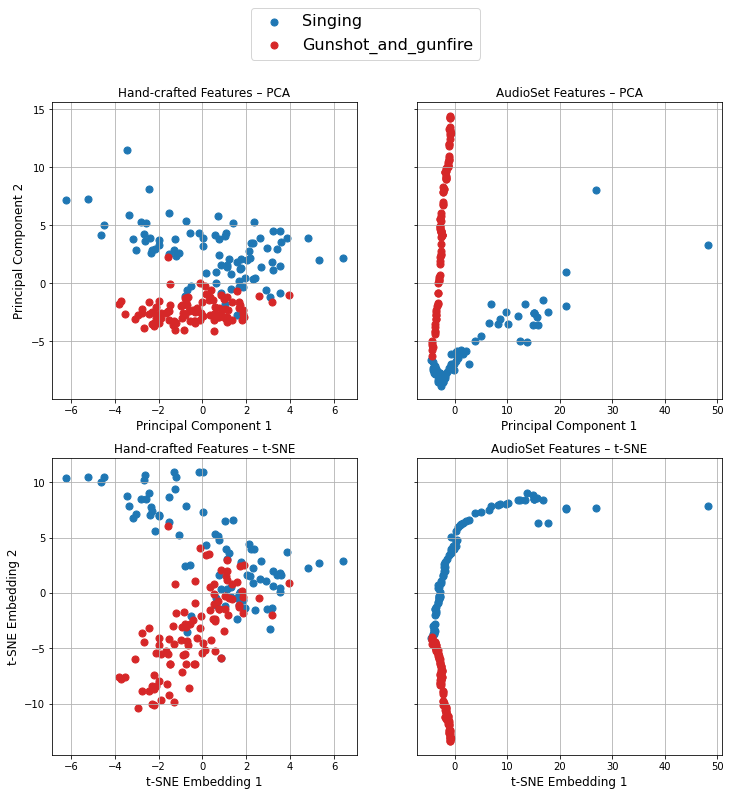

In [26]:
import matplotlib.pyplot as plt

labels = np.load("gt_labels_SvsG.npy")
CLASS_MAPPING = {
    0: 'Singing',
    1: 'Gunshot_and_gunfire',
}

fig, axs = plt.subplots(2,2, sharey='row')
fig.set_size_inches(12, 12, forward=True)
colors = ['tab:blue', 
          'tab:red']

axs[0, 0].set_xlabel('Principal Component 1', fontsize = 12)
axs[0, 0].set_ylabel('Principal Component 2', fontsize = 12)
axs[0, 0].set_title('Hand-crafted Features – PCA')
axs[0, 0].grid()
for idx in range(len(colors)):
    indicesToKeep = [i for i, x in enumerate(labels) if x == idx]
    axs[0, 0].scatter(hc_features_SvsG_pca[indicesToKeep, 1],
               hc_features_SvsG_pca[indicesToKeep, 0],
               c = colors[idx],
               s = 50,
               label = CLASS_MAPPING[idx])
fig.legend(loc='upper center', fontsize=16)

axs[0, 1].set_xlabel('Principal Component 1', fontsize = 12)
axs[0, 1].set_title('AudioSet Features – PCA')
axs[0, 1].grid()
for idx in range(len(colors)):
    indicesToKeep = [i for i, x in enumerate(labels) if x == idx]
    axs[0, 1].scatter(as_features_SvsG_pca[indicesToKeep, 1],
               as_features_SvsG_pca[indicesToKeep, 0],
               c = colors[idx],
               s = 50)
    
axs[1, 0].set_xlabel('t-SNE Embedding 1', fontsize = 12)
axs[1, 0].set_ylabel('t-SNE Embedding 2', fontsize = 12)
axs[1, 0].set_title('Hand-crafted Features – t-SNE')
axs[1, 0].grid()
for idx in range(len(colors)):
    indicesToKeep = [i for i, x in enumerate(labels) if x == idx]
    axs[1, 0].scatter(hc_features_SvsG_pca[indicesToKeep, 1],
               hc_features_SvsG_tsne[indicesToKeep, 0],
               c = colors[idx],
               s = 50)

axs[1, 1].set_xlabel('t-SNE Embedding 1', fontsize = 12)
axs[1, 1].set_title('AudioSet Features – t-SNE')
axs[1, 1].grid()
for idx in range(len(colors)):
    indicesToKeep = [i for i, x in enumerate(labels) if x == idx]
    axs[1, 1].scatter(as_features_SvsG_pca[indicesToKeep, 1],
               as_features_SvsG_tsne[indicesToKeep, 0],
               c = colors[idx],
               s = 50)

 ##### Fart vs. Bell

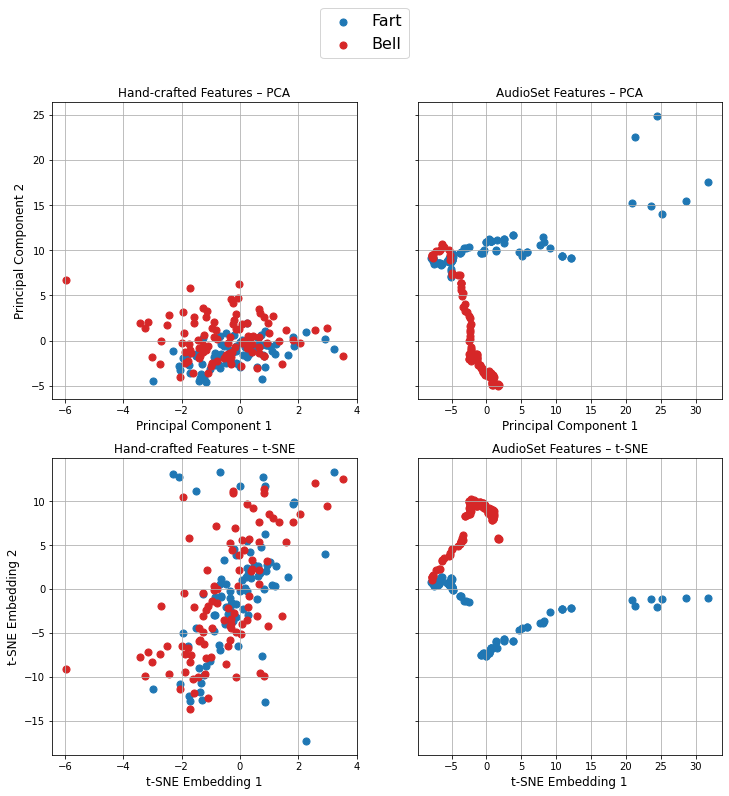

In [27]:
import matplotlib.pyplot as plt

labels = np.load("gt_labels_SvsG.npy")
CLASS_MAPPING = {
    0: 'Fart',
    1: 'Bell',
}

fig, axs = plt.subplots(2,2, sharey='row')
fig.set_size_inches(12, 12, forward=True)
colors = ['tab:blue', 
          'tab:red']

axs[0, 0].set_xlabel('Principal Component 1', fontsize = 12)
axs[0, 0].set_ylabel('Principal Component 2', fontsize = 12)
axs[0, 0].set_title('Hand-crafted Features – PCA')
axs[0, 0].grid()
for idx in range(len(colors)):
    indicesToKeep = [i for i, x in enumerate(labels) if x == idx]
    axs[0, 0].scatter(hc_features_FvsB_pca[indicesToKeep, 1],
               hc_features_FvsB_pca[indicesToKeep, 0],
               c = colors[idx],
               s = 50,
               label = CLASS_MAPPING[idx])
fig.legend(loc='upper center', fontsize=16)

axs[0, 1].set_xlabel('Principal Component 1', fontsize = 12)
axs[0, 1].set_title('AudioSet Features – PCA')
axs[0, 1].grid()
for idx in range(len(colors)):
    indicesToKeep = [i for i, x in enumerate(labels) if x == idx]
    axs[0, 1].scatter(as_features_FvsB_pca[indicesToKeep, 1],
               as_features_FvsB_pca[indicesToKeep, 0],
               c = colors[idx],
               s = 50)
    
axs[1, 0].set_xlabel('t-SNE Embedding 1', fontsize = 12)
axs[1, 0].set_ylabel('t-SNE Embedding 2', fontsize = 12)
axs[1, 0].set_title('Hand-crafted Features – t-SNE')
axs[1, 0].grid()
for idx in range(len(colors)):
    indicesToKeep = [i for i, x in enumerate(labels) if x == idx]
    axs[1, 0].scatter(hc_features_FvsB_pca[indicesToKeep, 1],
               hc_features_FvsB_tsne[indicesToKeep, 0],
               c = colors[idx],
               s = 50)

axs[1, 1].set_xlabel('t-SNE Embedding 1', fontsize = 12)
axs[1, 1].set_title('AudioSet Features – t-SNE')
axs[1, 1].grid()
for idx in range(len(colors)):
    indicesToKeep = [i for i, x in enumerate(labels) if x == idx]
    axs[1, 1].scatter(as_features_FvsB_pca[indicesToKeep, 1],
               as_features_FvsB_tsne[indicesToKeep, 0],
               c = colors[idx],
               s = 50)

## Evaluation
For evaluating the different methods used, we perform clustering on the datasets and measure the similarity between the real partition (given by the ground truth labels) and the one given by the clustering method. To measure this similarity, the Mutual Information score adjusted for chance (AMI) is used, which –the literature suggests– is suited when the reference clustering (the ground truth) is unbalanced and there exist small clusters.

The Mutual Information metric (MI) quantifies the information shared by the two partitions and therefore can be used as a clustering similarity measure. Values close to zero indicate two label assignments that are largely independent, while values close to one indicate significant agreement (exactly 1 indicates that the two label assignments are equal –with or without permutation).

Cluster the 8 different PCA and t-SNE embeddings obtained previously.

##### K-means clustering
Suitable for general-purpose, even cluster size, flat geometry, not too many clusters.


In [28]:
from sklearn.cluster import KMeans

# Kmeans clustering for the 8 combinations of methods and pairs of labels
hc_SvsG_pca_kmeans = KMeans(n_clusters=2, random_state=0).fit(hc_features_SvsG_pca)
as_SvsG_pca_kmeans = KMeans(n_clusters=2, random_state=0).fit(as_features_SvsG_pca)
hc_FvsB_pca_kmeans = KMeans(n_clusters=2, random_state=0).fit(hc_features_FvsB_pca)
as_FvsB_pca_kmeans = KMeans(n_clusters=2, random_state=0).fit(as_features_FvsB_pca)

hc_SvsG_tsne_kmeans = KMeans(n_clusters=2, random_state=0).fit(hc_features_SvsG_tsne)
as_SvsG_tsne_kmeans = KMeans(n_clusters=2, random_state=0).fit(as_features_SvsG_tsne)
hc_FvsB_tsne_kmeans = KMeans(n_clusters=2, random_state=0).fit(hc_features_FvsB_tsne)
as_FvsB_tsne_kmeans = KMeans(n_clusters=2, random_state=0).fit(as_features_FvsB_tsne)

Compare the clustering performed by the kMeans algorithm with the actual ground truth labels using the AMI score.

In [29]:
from sklearn.metrics.cluster import adjusted_mutual_info_score as ami

ami_hc_SvsG_pca = ami(np.load('gt_labels_SvsG.npy'), hc_SvsG_pca_kmeans.labels_)
ami_as_SvsG_pca = ami(np.load('gt_labels_SvsG.npy'), as_SvsG_pca_kmeans.labels_)
ami_hc_FvsB_pca = ami(np.load('gt_labels_FvsB.npy'), hc_FvsB_pca_kmeans.labels_)
ami_as_FvsB_pca = ami(np.load('gt_labels_FvsB.npy'), as_FvsB_pca_kmeans.labels_)

ami_hc_SvsG_tsne = ami(np.load('gt_labels_SvsG.npy'), hc_SvsG_tsne_kmeans.labels_)
ami_as_SvsG_tsne = ami(np.load('gt_labels_SvsG.npy'), as_SvsG_tsne_kmeans.labels_)
ami_hc_FvsB_tsne = ami(np.load('gt_labels_FvsB.npy'), hc_FvsB_tsne_kmeans.labels_)
ami_as_FvsB_tsne = ami(np.load('gt_labels_FvsB.npy'), as_FvsB_tsne_kmeans.labels_)

Save the scores as a dataframe and in a csv file.

In [30]:
import pandas as pd

data = [['Hand-crafted features + PCA', ami_hc_SvsG_pca, ami_hc_FvsB_pca],\
        ['Hand-crafted features + t-SNE', ami_hc_SvsG_tsne, ami_hc_FvsB_tsne],\
        ['AudioSet features + PCA', ami_as_SvsG_pca, ami_as_FvsB_pca],\
        ['AudioSet features + t-SNE', ami_as_SvsG_tsne, ami_as_FvsB_tsne]]

scores = pd.DataFrame(data, columns=['Method', 'Singing vs. Gunshot_and_gunfire', 'Fart vs. Bell'])
scores.to_csv('AMI_scores_kmeans.csv',index=False)

Plot the results obtained.

In [31]:
scores

,Method,Singing vs. Gunshot_and_gunfire,Fart vs. Bell
0,Hand-crafted features + PCA,0.590162,0.166031
1,Hand-crafted features + t-SNE,0.740058,-0.000254
2,AudioSet features + PCA,0.467586,0.639436
3,AudioSet features + t-SNE,0.598950,0.605409


Text(0, 0.5, 'Adjusted Mutual Information score')

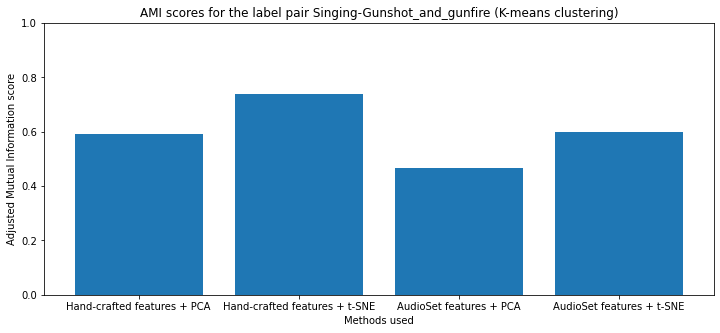

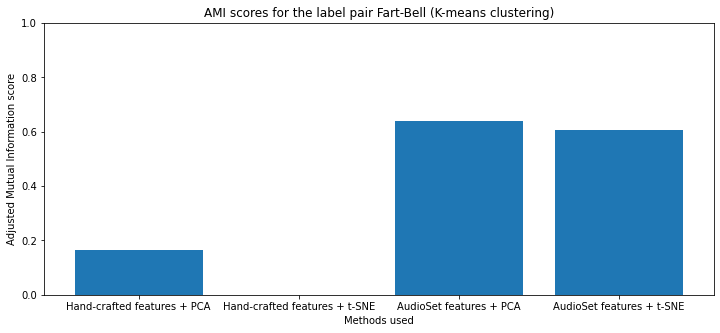

In [32]:
import matplotlib.pyplot as plt

# Singing vs. Gunshot_and_gunfire
plt.figure(figsize=[12,5])
plt.title("AMI scores for the label pair Singing-Gunshot_and_gunfire (K-means clustering)")
y = list(scores['Singing vs. Gunshot_and_gunfire'])
x_text = list(scores['Method'])
x = range(len(x_text))
plt.bar(x, y, align='center')
plt.xticks(x, x_text)
plt.ylim([0,1])
plt.xlabel('Methods used')
plt.ylabel('Adjusted Mutual Information score')

# Fart vs Bell
plt.figure(figsize=[12,5])
plt.title("AMI scores for the label pair Fart-Bell (K-means clustering)")
y = list(scores['Fart vs. Bell'])
x_text = list(scores['Method'])
x = range(len(x_text))
plt.bar(x, y, align='center')
plt.xticks(x, x_text)
plt.ylim([0,1])
plt.xlabel('Methods used')
plt.ylabel('Adjusted Mutual Information score')

Nonetheless, K-means clustering makes some implicit assumptions on the data, which are: clusters have equal variance ("spherical" clusters) and clusters are of similar size. These are assumptions that the data –and specially the AudioSet features with both PCA and t-SNE reductions– may not obey. 

For this reason, other clustering methods should be used to evaluate.

##### Spectral clustering
This method is recommended for few clusters, with non-flat geometry, and even cluster sizes (see [scikit-learn clustering reference](https://scikit-learn.org/stable/modules/clustering.html)).

,Method,Singing vs. Gunshot_and_gunfire,Fart vs. Bell
0,Hand-crafted features + PCA,0.259535,0.024970
1,Hand-crafted features + t-SNE,0.802598,0.006028
2,AudioSet features + PCA,0.001251,0.016266
3,AudioSet features + t-SNE,0.709016,0.373859


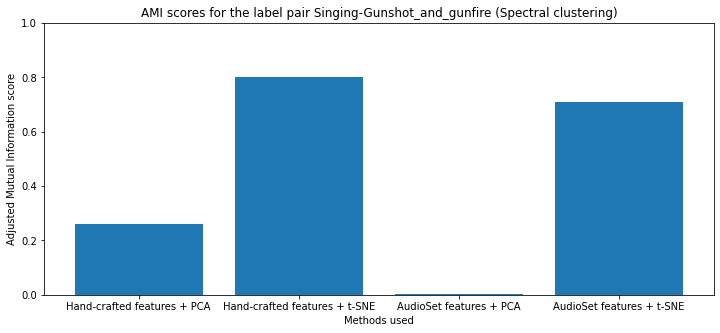

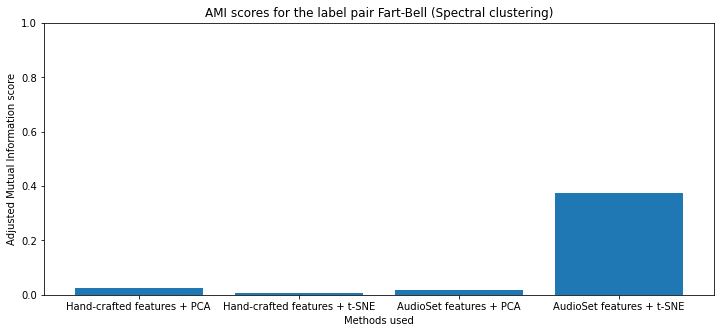

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import adjusted_mutual_info_score as ami

# Spectral clustering for the 8 combinations of methods and pairs of labels
hc_SvsG_pca_spectral = SpectralClustering(n_clusters=2, random_state=543).fit(hc_features_SvsG_pca)
as_SvsG_pca_spectral = SpectralClustering(n_clusters=2, random_state=543).fit(as_features_SvsG_pca)
hc_FvsB_pca_spectral = SpectralClustering(n_clusters=2, random_state=543).fit(hc_features_FvsB_pca)
as_FvsB_pca_spectral = SpectralClustering(n_clusters=2, random_state=543).fit(as_features_FvsB_pca)

hc_SvsG_tsne_spectral = SpectralClustering(n_clusters=2, random_state=543).fit(hc_features_SvsG_tsne)
as_SvsG_tsne_spectral = SpectralClustering(n_clusters=2, random_state=543).fit(as_features_SvsG_tsne)
hc_FvsB_tsne_spectral = SpectralClustering(n_clusters=2, random_state=543).fit(hc_features_FvsB_tsne)
as_FvsB_tsne_spectral = SpectralClustering(n_clusters=2, random_state=543).fit(as_features_FvsB_tsne)

# AMI scores
ami_hc_SvsG_pca = ami(np.load('gt_labels_SvsG.npy'), hc_SvsG_pca_spectral.labels_)
ami_as_SvsG_pca = ami(np.load('gt_labels_SvsG.npy'), as_SvsG_pca_spectral.labels_)
ami_hc_FvsB_pca = ami(np.load('gt_labels_FvsB.npy'), hc_FvsB_pca_spectral.labels_)
ami_as_FvsB_pca = ami(np.load('gt_labels_FvsB.npy'), as_FvsB_pca_spectral.labels_)

ami_hc_SvsG_tsne = ami(np.load('gt_labels_SvsG.npy'), hc_SvsG_tsne_spectral.labels_)
ami_as_SvsG_tsne = ami(np.load('gt_labels_SvsG.npy'), as_SvsG_tsne_spectral.labels_)
ami_hc_FvsB_tsne = ami(np.load('gt_labels_FvsB.npy'), hc_FvsB_tsne_spectral.labels_)
ami_as_FvsB_tsne = ami(np.load('gt_labels_FvsB.npy'), as_FvsB_tsne_spectral.labels_)

data = [['Hand-crafted features + PCA', ami_hc_SvsG_pca, ami_hc_FvsB_pca],\
        ['Hand-crafted features + t-SNE', ami_hc_SvsG_tsne, ami_hc_FvsB_tsne],\
        ['AudioSet features + PCA', ami_as_SvsG_pca, ami_as_FvsB_pca],\
        ['AudioSet features + t-SNE', ami_as_SvsG_tsne, ami_as_FvsB_tsne]]

scores = pd.DataFrame(data, columns=['Method', 'Singing vs. Gunshot_and_gunfire', 'Fart vs. Bell'])
scores.to_csv('AMI_scores_spectral.csv',index=False)

# Singing vs. Gunshot_and_gunfire
plt.figure(figsize=[12,5])
plt.title("AMI scores for the label pair Singing-Gunshot_and_gunfire (Spectral clustering)")
y = list(scores['Singing vs. Gunshot_and_gunfire'])
x_text = list(scores['Method'])
x = range(len(x_text))
plt.bar(x, y, align='center')
plt.xticks(x, x_text)
plt.ylim([0,1])
plt.xlabel('Methods used')
plt.ylabel('Adjusted Mutual Information score')

# Fart vs Bell
plt.figure(figsize=[12,5])
plt.title("AMI scores for the label pair Fart-Bell (Spectral clustering)")
y = list(scores['Fart vs. Bell'])
x_text = list(scores['Method'])
x = range(len(x_text))
plt.bar(x, y, align='center')
plt.xticks(x, x_text)
plt.ylim([0,1])
plt.xlabel('Methods used')
plt.ylabel('Adjusted Mutual Information score')

scores

##### OPTICS
Recommended for non-flat geometry, uneven cluster sizes and variable cluster density. Note that it does not have a parameter to specify the number of clusters, so it can ouput more than two.

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


,Method,Singing vs. Gunshot_and_gunfire,Fart vs. Bell
0,Hand-crafted features + PCA,0.186458,0.094709
1,Hand-crafted features + t-SNE,0.194815,0.149683
2,AudioSet features + PCA,0.280293,0.227965
3,AudioSet features + t-SNE,0.258091,0.240281


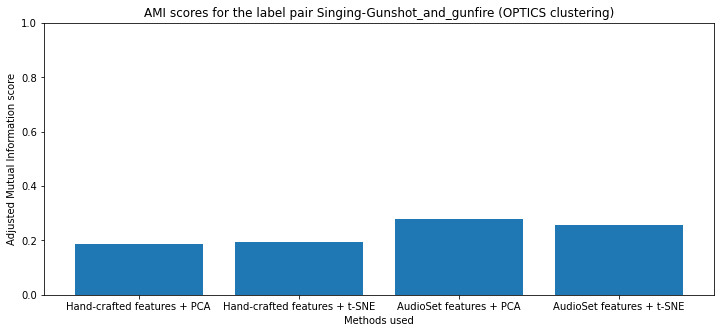

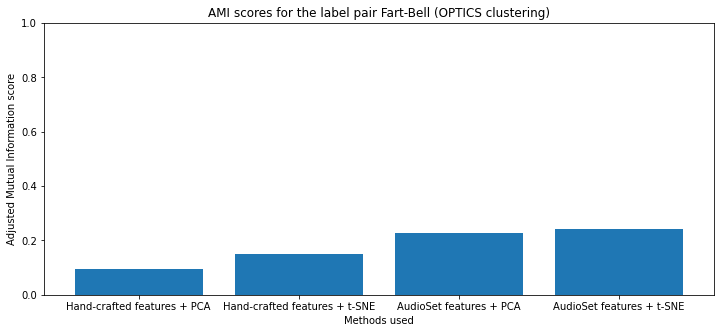

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import OPTICS
from sklearn.metrics.cluster import adjusted_mutual_info_score as ami

# OPTICS clustering for the 8 combinations of methods and pairs of labels
hc_SvsG_pca_opt = OPTICS().fit(hc_features_SvsG_pca)
as_SvsG_pca_opt = OPTICS().fit(as_features_SvsG_pca)
hc_FvsB_pca_opt = OPTICS().fit(hc_features_FvsB_pca)
as_FvsB_pca_opt = OPTICS().fit(as_features_FvsB_pca)

hc_SvsG_tsne_opt = OPTICS().fit(hc_features_SvsG_tsne)
as_SvsG_tsne_opt = OPTICS().fit(as_features_SvsG_tsne)
hc_FvsB_tsne_opt = OPTICS().fit(hc_features_FvsB_tsne)
as_FvsB_tsne_opt = OPTICS().fit(as_features_FvsB_tsne)

# AMI scores
ami_hc_SvsG_pca = ami(np.load('gt_labels_SvsG.npy'), hc_SvsG_pca_opt.labels_)
ami_as_SvsG_pca = ami(np.load('gt_labels_SvsG.npy'), as_SvsG_pca_opt.labels_)
ami_hc_FvsB_pca = ami(np.load('gt_labels_FvsB.npy'), hc_FvsB_pca_opt.labels_)
ami_as_FvsB_pca = ami(np.load('gt_labels_FvsB.npy'), as_FvsB_pca_opt.labels_)

ami_hc_SvsG_tsne = ami(np.load('gt_labels_SvsG.npy'), hc_SvsG_tsne_opt.labels_)
ami_as_SvsG_tsne = ami(np.load('gt_labels_SvsG.npy'), as_SvsG_tsne_opt.labels_)
ami_hc_FvsB_tsne = ami(np.load('gt_labels_FvsB.npy'), hc_FvsB_tsne_opt.labels_)
ami_as_FvsB_tsne = ami(np.load('gt_labels_FvsB.npy'), as_FvsB_tsne_opt.labels_)

data = [['Hand-crafted features + PCA', ami_hc_SvsG_pca, ami_hc_FvsB_pca],\
        ['Hand-crafted features + t-SNE', ami_hc_SvsG_tsne, ami_hc_FvsB_tsne],\
        ['AudioSet features + PCA', ami_as_SvsG_pca, ami_as_FvsB_pca],\
        ['AudioSet features + t-SNE', ami_as_SvsG_tsne, ami_as_FvsB_tsne]]

scores = pd.DataFrame(data, columns=['Method', 'Singing vs. Gunshot_and_gunfire', 'Fart vs. Bell'])
scores.to_csv('AMI_scores_optics.csv',index=False)

# Singing vs. Gunshot_and_gunfire
plt.figure(figsize=[12,5])
plt.title("AMI scores for the label pair Singing-Gunshot_and_gunfire (OPTICS clustering)")
y = list(scores['Singing vs. Gunshot_and_gunfire'])
x_text = list(scores['Method'])
x = range(len(x_text))
plt.bar(x, y, align='center')
plt.xticks(x, x_text)
plt.ylim([0,1])
plt.xlabel('Methods used')
plt.ylabel('Adjusted Mutual Information score')

# Fart vs Bell
plt.figure(figsize=[12,5])
plt.title("AMI scores for the label pair Fart-Bell (OPTICS clustering)")
y = list(scores['Fart vs. Bell'])
x_text = list(scores['Method'])
x = range(len(x_text))
plt.bar(x, y, align='center')
plt.xticks(x, x_text)
plt.ylim([0,1])
plt.xlabel('Methods used')
plt.ylabel('Adjusted Mutual Information score')

scores

##### Agglomerative clustering
A hierarchical clustering that uses a bottom up approach –each observation starts in its own cluster, and clusters are successively merged together.

,Method,Singing vs. Gunshot_and_gunfire,Fart vs. Bell
0,Hand-crafted features + PCA,0.612184,0.153675
1,Hand-crafted features + t-SNE,0.618784,0.001524
2,AudioSet features + PCA,0.598950,0.729417
3,AudioSet features + t-SNE,0.709016,0.718289


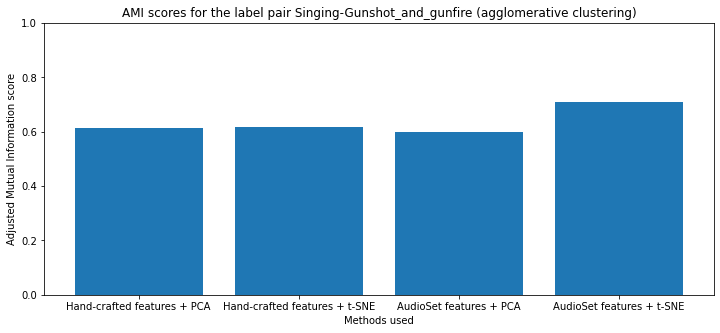

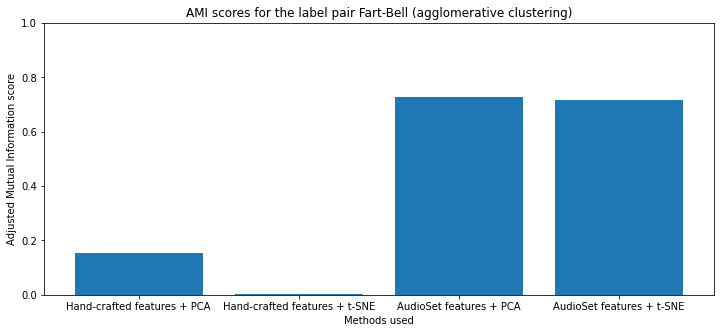

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering as AggClust
from sklearn.metrics.cluster import adjusted_mutual_info_score as ami

# Agglomerative clustering for the 8 combinations of methods and pairs of labels
hc_SvsG_pca_agglo = AggClust(n_clusters=2,linkage='ward').fit(hc_features_SvsG_pca)
as_SvsG_pca_agglo = AggClust(n_clusters=2,linkage='ward').fit(as_features_SvsG_pca)
hc_FvsB_pca_agglo = AggClust(n_clusters=2,linkage='ward').fit(hc_features_FvsB_pca)
as_FvsB_pca_agglo = AggClust(n_clusters=2,linkage='ward').fit(as_features_FvsB_pca)

hc_SvsG_tsne_agglo = AggClust(n_clusters=2,linkage='ward').fit(hc_features_SvsG_tsne)
as_SvsG_tsne_agglo = AggClust(n_clusters=2,linkage='ward').fit(as_features_SvsG_tsne)
hc_FvsB_tsne_agglo = AggClust(n_clusters=2,linkage='ward').fit(hc_features_FvsB_tsne)
as_FvsB_tsne_agglo = AggClust(n_clusters=2,linkage='ward').fit(as_features_FvsB_tsne)

# AMI scores
ami_hc_SvsG_pca = ami(np.load('gt_labels_SvsG.npy'), hc_SvsG_pca_agglo.labels_)
ami_as_SvsG_pca = ami(np.load('gt_labels_SvsG.npy'), as_SvsG_pca_agglo.labels_)
ami_hc_FvsB_pca = ami(np.load('gt_labels_FvsB.npy'), hc_FvsB_pca_agglo.labels_)
ami_as_FvsB_pca = ami(np.load('gt_labels_FvsB.npy'), as_FvsB_pca_agglo.labels_)

ami_hc_SvsG_tsne = ami(np.load('gt_labels_SvsG.npy'), hc_SvsG_tsne_agglo.labels_)
ami_as_SvsG_tsne = ami(np.load('gt_labels_SvsG.npy'), as_SvsG_tsne_agglo.labels_)
ami_hc_FvsB_tsne = ami(np.load('gt_labels_FvsB.npy'), hc_FvsB_tsne_agglo.labels_)
ami_as_FvsB_tsne = ami(np.load('gt_labels_FvsB.npy'), as_FvsB_tsne_agglo.labels_)

data = [['Hand-crafted features + PCA', ami_hc_SvsG_pca, ami_hc_FvsB_pca],\
        ['Hand-crafted features + t-SNE', ami_hc_SvsG_tsne, ami_hc_FvsB_tsne],\
        ['AudioSet features + PCA', ami_as_SvsG_pca, ami_as_FvsB_pca],\
        ['AudioSet features + t-SNE', ami_as_SvsG_tsne, ami_as_FvsB_tsne]]

scores = pd.DataFrame(data, columns=['Method', 'Singing vs. Gunshot_and_gunfire', 'Fart vs. Bell'])
scores.to_csv('AMI_scores_agglomerative.csv',index=False)

# Singing vs. Gunshot_and_gunfire
plt.figure(figsize=[12,5])
plt.title("AMI scores for the label pair Singing-Gunshot_and_gunfire (agglomerative clustering)")
y = list(scores['Singing vs. Gunshot_and_gunfire'])
x_text = list(scores['Method'])
x = range(len(x_text))
plt.bar(x, y, align='center')
plt.xticks(x, x_text)
plt.ylim([0,1])
plt.xlabel('Methods used')
plt.ylabel('Adjusted Mutual Information score')

# Fart vs Bell
plt.figure(figsize=[12,5])
plt.title("AMI scores for the label pair Fart-Bell (agglomerative clustering)")
y = list(scores['Fart vs. Bell'])
x_text = list(scores['Method'])
x = range(len(x_text))
plt.bar(x, y, align='center')
plt.xticks(x, x_text)
plt.ylim([0,1])
plt.xlabel('Methods used')
plt.ylabel('Adjusted Mutual Information score')

scores

### Conclusion
It can be observed that the clustering method has a direct influence in the AMI score obtained in the evaluation. This makes sense, as each clustering method makes some assumtions on the data, resulting in successful or unsuccessful clusterings. Therefore, it is important to compare between different clustering methods. 

K-means and agglomerative clustering methods seem to deliver similar results in this case (also because they are similar methods), suggesting that they provide correct clusters for the data. Moreover, these results agree with what can be observed in the plotting of ground truths, where the hand-crafted features both with PCA and t-SNE reductions of the label pair Fart-Bell seem difficult to cluster –thus, they score close to zero–; whereas the AudioSet features seem separable –so they score closer to one.

Another observation is that the AudioSet features, obtained with the VGGish pretrained model, seem to distinguish timbre considerably better than hand-crafted features for the case of Fart vs. Bell, as is suggested in the [consulted literature](https://arxiv.org/pdf/2004.03985.pdf). However, the former features perform slighly better than the latter ones in the case of Singing vs. Gunshot_and_gunfire. In any case, it is difficult to know whether this difference is significant or not, and consequently more contrasting labels should be compared as further work.

Regarding the PCA and the t-SNE dimensionality reduction methods, there does not seem to be a significant difference between them –although once again, it is intricate to measure significance having only four scores available. Nonetheless, it has been observed during the implementation of the t-SNE method, that the random initialization of this method varies the output substantially. This means that the clustering carried out after t-SNE could perform better with a different initialization, which is not known a priori. PCA is therefore more stable when compared to t-SNE.

In addition to this, there are other factors that have not been taken into account, such as the interpretability and time efficiency of each method. This could be further work in the comparison of the different  2-D timbre spaces.

